### UPD:

    Возможно я что-то не понял, но данных очень мало для какого либо анализа.
    Также они достаточно "грязные" не только в плане аудио, но и названий.
    Полноценное понимание аудио данных и методов их анализа, требует более глубокого погружения в тему, чем я смог выделить в данный момент.
    

# Блок 1 — Загрузка данных и "нормализация" меток

In [1]:
from pathlib import Path
import json
import pandas as pd

# указываем константы путей
DATASET_ROOT = Path("ai-mechanic-export")
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

def read_info_labels_file(info_labels_path: Path, dataset_root: Path) -> pd.DataFrame:
    if not info_labels_path.exists():
        return pd.DataFrame(columns=["filepath", "split", "raw_label"])

    info_content = json.loads(info_labels_path.read_text(encoding="utf-8"))
    file_entries = info_content.get("files", [])

    records = []
    for file_entry in file_entries:
        relative_path = Path(file_entry.get("path", ""))
        split_name = relative_path.parts[0] if len(relative_path.parts) > 0 else file_entry.get("category", "")
        absolute_file_path = (dataset_root / relative_path).resolve()
        raw_label_text = (file_entry.get("label", {}) or {}).get("label", "")

        records.append({
            "filepath": str(absolute_file_path),
            "split": split_name,
            "raw_label": raw_label_text,
        })

    df = pd.DataFrame(records).drop_duplicates(subset=["filepath"])
    df = df[df["filepath"].apply(lambda p: Path(p).exists())].copy()
    return df

def normalize_label_text(text: str) -> str:
    # Убираем лишние пробелы
    text = (text or "").lower().strip()
    return " ".join(text.split())

# Наборы соответствий сырой метки -> укрупнённый класс задачи
LABELS_TO_BACKGROUND = {"background noise", "background"}
LABELS_TO_NORMAL     = {"idling", "normal engine inside cabin"}
LABELS_TO_FAULTY     = {"air leak", "air leak engine inside cabin", "oil cap off engine inside cabin"}

def map_raw_to_target(normalized_text: str):
    if normalized_text in LABELS_TO_BACKGROUND:
        return "background_noise"
    if normalized_text in LABELS_TO_NORMAL:
        return "normal"
    if normalized_text in LABELS_TO_FAULTY:
        return "faulty"
    return None

def build_labels_dataframes(dataset_root: Path):
   
    info_paths = [
        dataset_root / "info.labels",
        dataset_root / "training" / "info.labels",
        dataset_root / "testing" / "info.labels"]

    # удаляем дубликаты
    list_of_frames = [read_info_labels_file(path, dataset_root) for path in info_paths]
    all_files_df = pd.concat(list_of_frames, ignore_index=True).drop_duplicates(subset=["filepath"])
    all_files_df = all_files_df[all_files_df["filepath"].apply(lambda p: Path(p).exists())].copy()

    all_files_df["normalized_label"] = all_files_df["raw_label"].map(normalize_label_text)
    all_files_df["target"] = all_files_df["normalized_label"].map(map_raw_to_target)

    train_df = all_files_df[
        (all_files_df["split"] == "training") & (all_files_df["target"].notna())
    ].copy()

    test_df = all_files_df[all_files_df["split"] == "testing"].copy()

    return all_files_df, train_df, test_df

# запускаем обработку
all_df, train_df, test_df = build_labels_dataframes(DATASET_ROOT)

train_df.to_csv(ARTIFACTS_DIR / "labels_train.csv", index=False)
test_df.to_csv(ARTIFACTS_DIR / "labels_test.csv", index=False)

print("Файлов для обучения по классам:")
print(train_df["target"].value_counts(dropna=False))
print(f"Всего тестовых файлов: {len(test_df)}")

display(train_df.tail())


Файлов для обучения по классам:
target
faulty              17
normal              10
background_noise     7
Name: count, dtype: int64
Всего тестовых файлов: 5


filepath     split  \
34  C:\Users\053458\Desktop\ML\gerion\ai-mechanic-...  training   
35  C:\Users\053458\Desktop\ML\gerion\ai-mechanic-...  training   
36  C:\Users\053458\Desktop\ML\gerion\ai-mechanic-...  training   
37  C:\Users\053458\Desktop\ML\gerion\ai-mechanic-...  training   
38  C:\Users\053458\Desktop\ML\gerion\ai-mechanic-...  training   

           raw_label  normalized_label            target  
34          air leak          air leak            faulty  
35          air leak          air leak            faulty  
36  Background Noise  background noise  background_noise  
37  Background Noise  background noise  background_noise  
38  background noise  background noise  background_noise

# Блок 2 — EDA: длительности, примеры сигналов, SNR

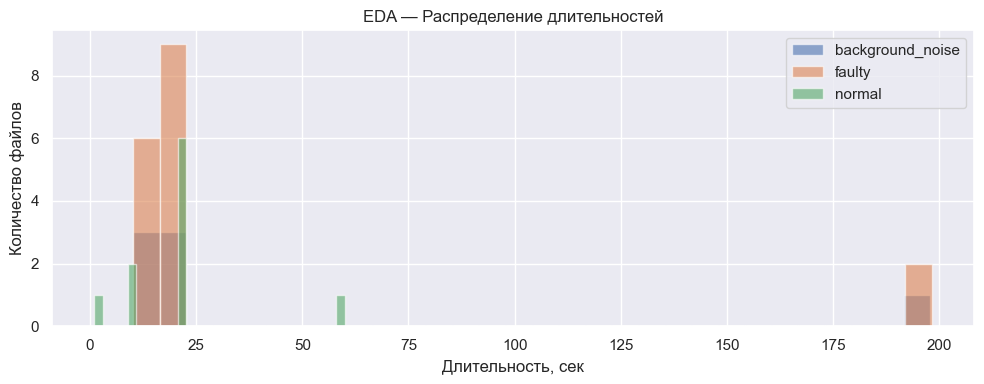

duration_s                                                \
                      count    mean     std     min     25%    50%    75%   
target                                                                      
background_noise        7.0  41.655  69.112  10.112  10.112  21.12  21.12   
faulty                 17.0  38.066  60.493  10.112  10.112  21.12  21.12   
normal                 10.0  20.794  15.484   1.000  12.864  21.12  21.12   

                           
                      max  
target                     
background_noise  197.888  
faulty            198.315  
normal             60.000

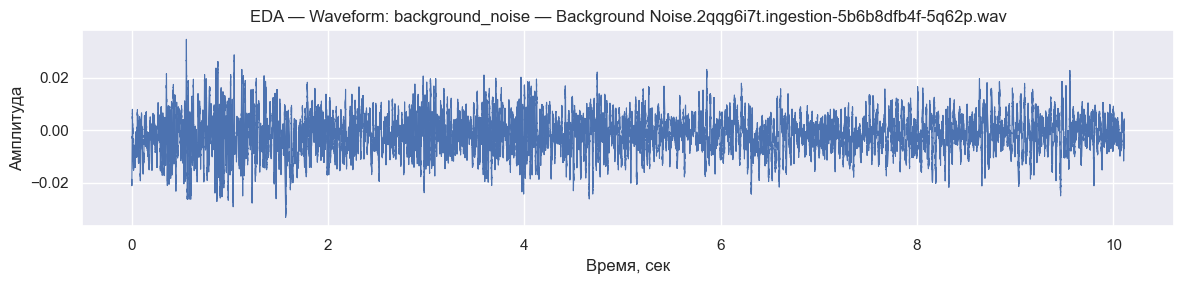

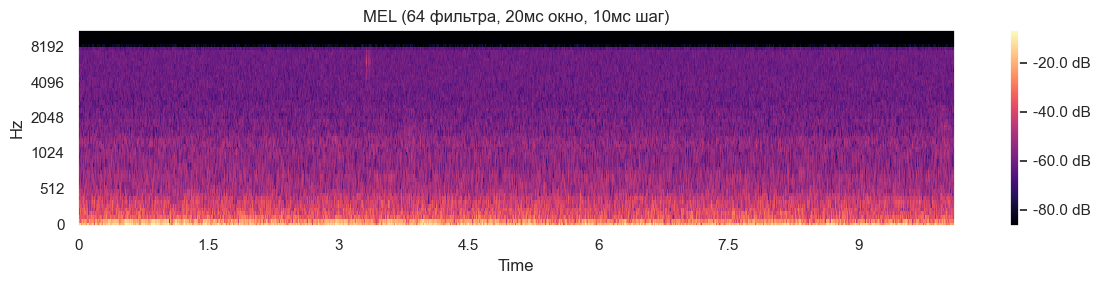

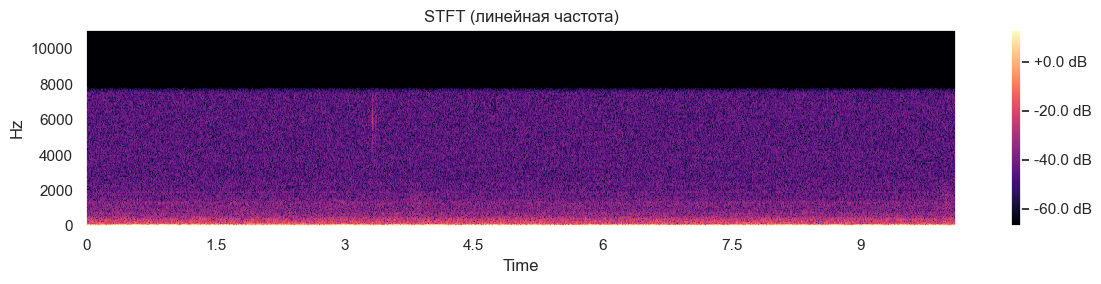

C:\Users\053458\AppData\Local\Temp\ipykernel_21312\2789636834.py:113: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(cqt_db, sr=target_sr, hop_length=hop_samples,


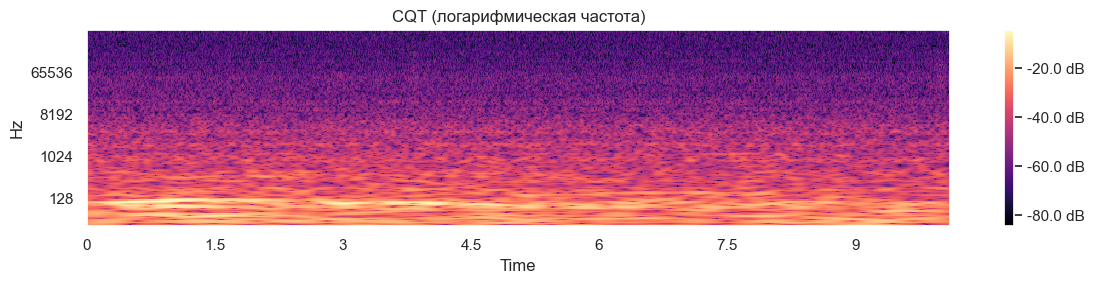

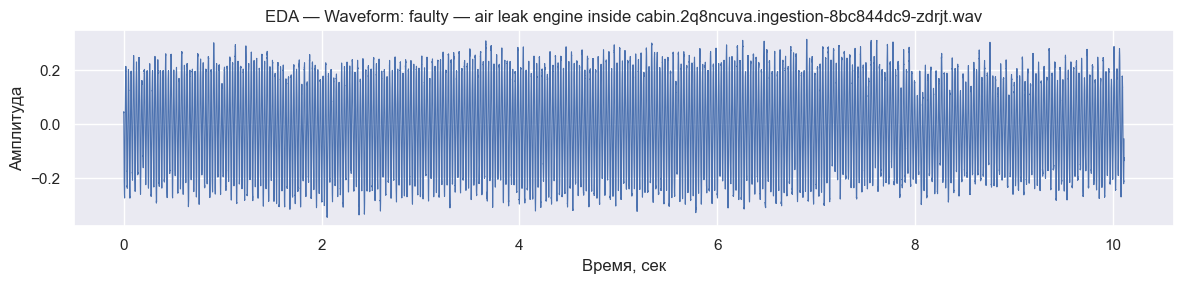

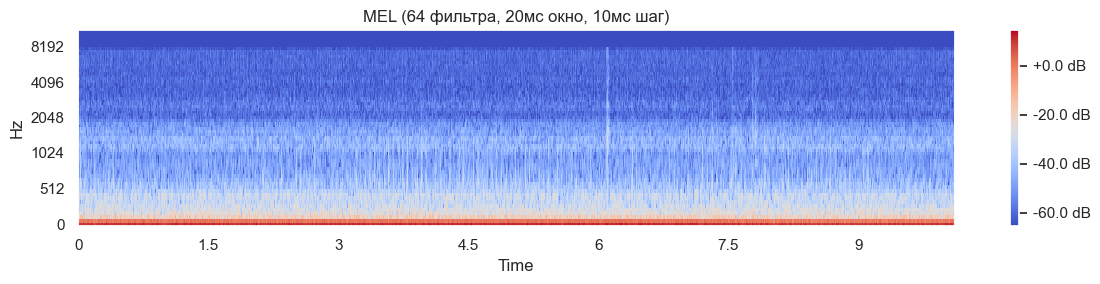

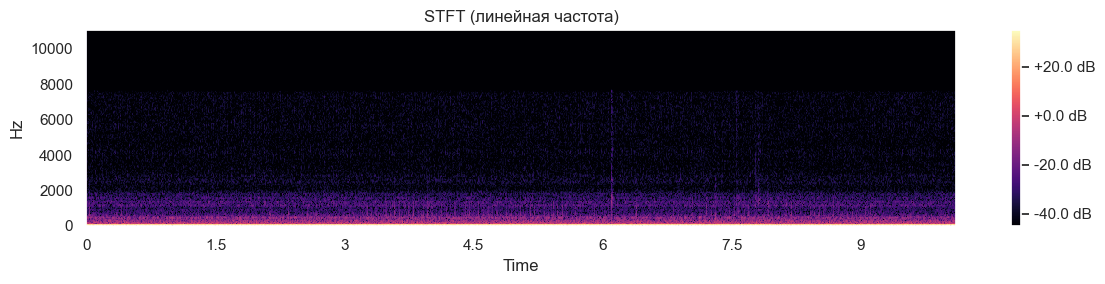

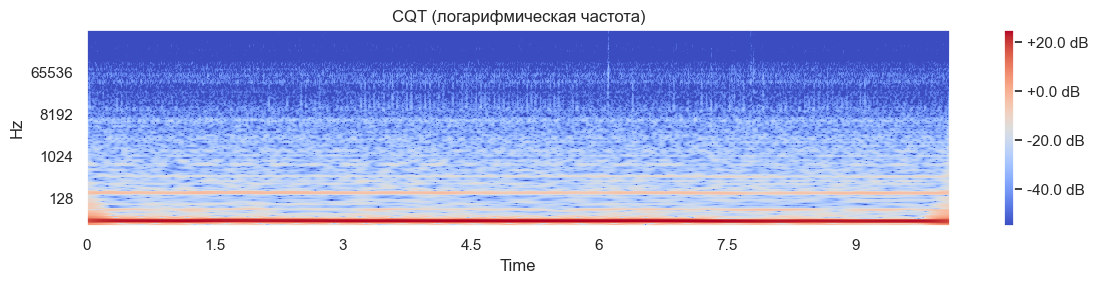

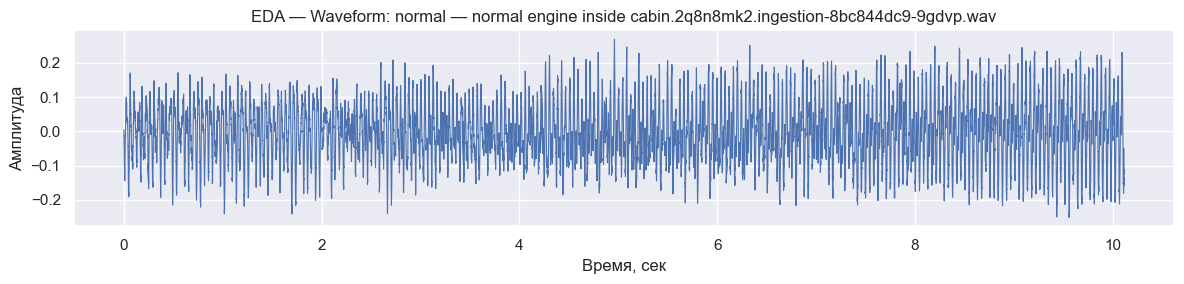

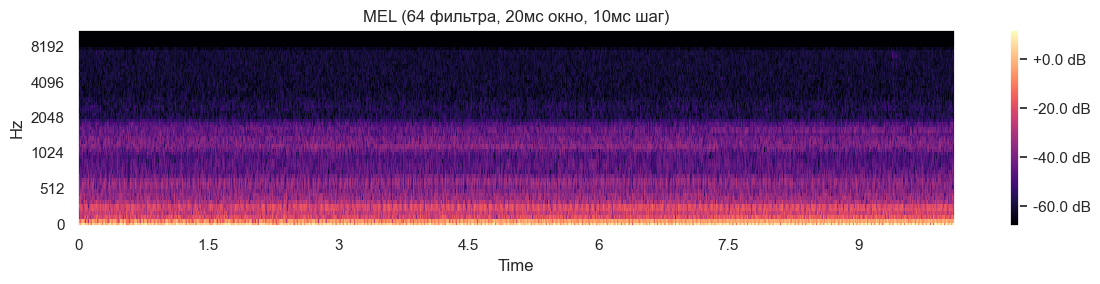

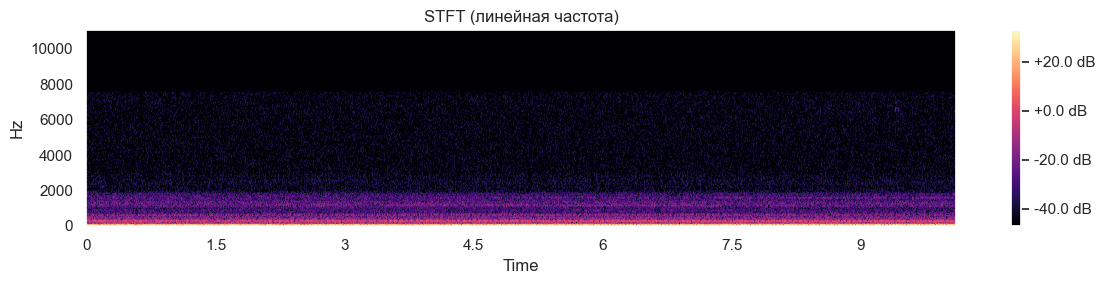

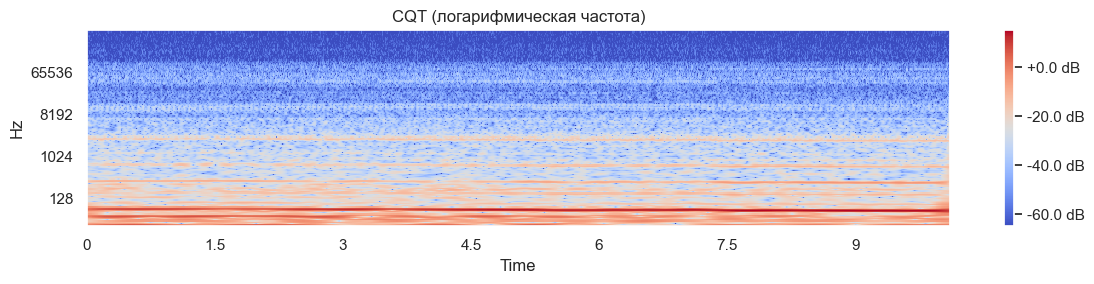

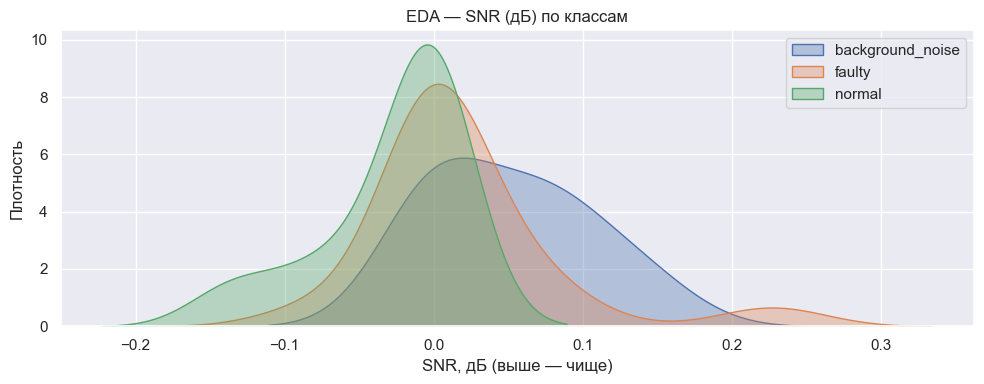

snr_db                                                 
                  count   mean    std    min    25%    50%    75%    max
target                                                                  
background_noise    7.0  0.051  0.054  0.000  0.000  0.049  0.083  0.140
faulty             17.0  0.019  0.063 -0.080  0.000  0.000  0.000  0.227
normal             10.0 -0.028  0.047 -0.134 -0.039 -0.000  0.000  0.001

In [2]:
import numpy as np                             
import soundfile as sf                         
import librosa, librosa.display                
import scipy.signal as sp_signal               
import matplotlib.pyplot as plt                
import seaborn as sns                          
from IPython.display import Audio, display     


artifacts_dir = Path("artifacts")              
labels_train_csv = artifacts_dir / "labels_train.csv"

# КОНСТАНТЫ для анализа из репозитория
target_sr = 22_050                             # частота дискретизации (Гц)
frame_len_sec = 0.020                          # длина окна анализа 20 мс
hop_len_sec   = 0.010                          # перекрытие (шаг 10 мс)
n_mels        = 64                             # количество MEL-фильтров

n_fft      = int(target_sr * frame_len_sec)    # размер окна БПФ для STFT (в сэмплах)
hop_samples= int(target_sr * hop_len_sec)      # шаг между окнами (в сэмплах)

# задали тему графиков
sns.set_theme(style="darkgrid", context="notebook")

# загрузка WAV: моно + ресэмплинг к target_sr
def load_audio_mono_resampled(wav_path: Path, sr: int = target_sr):
    signal, orig_sr = sf.read(wav_path)
    # eсли 2 канала
    if signal.ndim > 1:                               
        signal = signal.mean(axis=1)                  
    if orig_sr != sr:                                 
        signal = librosa.resample(y=signal, orig_sr=orig_sr, target_sr=sr)
    # возвращаем float32 + целевую sr    
    return signal.astype(np.float32), sr              

# оценка SNR
def estimate_snr_db(signal):
    # шум = исходный сигнал - «сглаженная» версия;
    # SNR = 10*log10(Psignal / Pnoise)
    eps = 1e-12                                     
    centered = signal - np.mean(signal)              
    p_signal = np.mean(centered**2) + eps            
    # подбираем безопасный нечётный размер окна медианного фильтра 
    kernel = max(3, (len(centered)//50)*2 + 1)       
    if kernel % 2 == 0: kernel += 1                  
    smooth = sp_signal.medfilt(centered, kernel_size=kernel)  
    noise_like = centered - smooth                   
    p_noise  = np.mean(noise_like**2) + eps          
    return float(10*np.log10(p_signal/p_noise))      

# распределение длительностей записей по классам
def plot_duration_histogram(eda_df):
    plt.figure(figsize=(10,4))
    for cls in sorted(eda_df["target"].unique()):                    
        plt.hist(eda_df[eda_df["target"]==cls]["duration_s"],        
                 bins=30, alpha=0.6, label=cls)                      
    plt.title("EDA — Распределение длительностей")
    plt.xlabel("Длительность, сек")
    plt.ylabel("Количество файлов")
    plt.legend()
    plt.tight_layout()
    plt.show()

# KDE SNR по классам
def plot_snr_kde(eda_df):
    plt.figure(figsize=(10,4))
    for cls in sorted(eda_df["target"].unique()):
        sns.kdeplot(eda_df[eda_df["target"]==cls]["snr_db"],         
                    label=cls, fill=True, alpha=0.35)               
    plt.title("EDA — SNR (дБ) по классам")
    plt.xlabel("SNR, дБ (выше — чище)")
    plt.ylabel("Плотность")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Пример waveform + MEL + STFT + CQT + плеер
def show_example(wav_path: Path, title: str = None):
    signal, _ = load_audio_mono_resampled(wav_path, target_sr)       
    # 5.1) Временная форма
    t = np.arange(len(signal))/target_sr
    plt.figure(figsize=(12,3))
    plt.plot(t, signal, linewidth=0.8)
    plt.title(f"EDA — Waveform: {title or wav_path.name}")
    plt.xlabel("Время, сек"); plt.ylabel("Амплитуда")
    plt.tight_layout(); plt.show()

    
    mel_power = librosa.feature.melspectrogram(y=signal, sr=target_sr,
                                               n_fft=n_fft, hop_length=hop_samples, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel_power + 1e-10)                 
    plt.figure(figsize=(12,3))
    librosa.display.specshow(mel_db, sr=target_sr, hop_length=hop_samples,
                             x_axis="time", y_axis="mel")
    plt.colorbar(format="%+0.1f dB"); plt.title("MEL (64 фильтра, 20мс окно, 10мс шаг)")
    plt.tight_layout(); plt.show()

    # STFT-спектрограмма
    stft = librosa.stft(y=signal, n_fft=n_fft, hop_length=hop_samples,
                        win_length=n_fft, window="hann")
    stft_db = librosa.amplitude_to_db(np.abs(stft) + 1e-10)
    plt.figure(figsize=(12,3))
    librosa.display.specshow(stft_db, sr=target_sr, hop_length=hop_samples,
                             x_axis="time", y_axis="hz")
    plt.colorbar(format="%+0.1f dB"); plt.title("STFT (линейная частота)")
    plt.tight_layout(); plt.show()

    # CQT-спектрограмма (логарифмическая / музыкальная шкала — лучше видны гармоники)
    cqt = librosa.cqt(y=signal, sr=target_sr, hop_length=hop_samples,
                      bins_per_octave=24, n_bins=7*24)
    cqt_db = librosa.amplitude_to_db(np.abs(cqt) + 1e-10)
    plt.figure(figsize=(12,3))
    librosa.display.specshow(cqt_db, sr=target_sr, hop_length=hop_samples,
                             x_axis="time", y_axis="cqt_hz")
    plt.colorbar(format="%+0.1f dB"); plt.title("CQT (логарифмическая частота)")
    plt.tight_layout(); plt.show()

    # интерактивный проигрыватель аудио
    display(Audio(signal, rate=target_sr))


train_df = pd.read_csv(labels_train_csv)               
eda_csv = artifacts_dir / "eda.csv"
if eda_csv.exists():                                   
    eda_df = pd.read_csv(eda_csv)                      
else:
    rows = []                                          
    for _, row in train_df.iterrows():                 
        wav_path = Path(row["filepath"])
        target = row["target"]
        signal, sr = load_audio_mono_resampled(wav_path, target_sr)
        duration_s = len(signal) / sr                  
        snr_db = estimate_snr_db(signal)               
        rows.append({"filepath": str(wav_path),
                     "target": target,
                     "duration_s": duration_s,
                     "snr_db": snr_db})
    eda_df = pd.DataFrame(rows)
    eda_df.to_csv(eda_csv, index=False)                

# гистограмма длительностей
plot_duration_histogram(eda_df)
display(eda_df.groupby("target")[["duration_s"]].describe().round(3))

# примеру на кажыдй класс (waveform+спектры+плеер)
for cls in sorted(train_df["target"].unique()):
    one = train_df[train_df["target"]==cls].head(1)    
    for _, r in one.iterrows():
        show_example(Path(r["filepath"]), title=f"{cls} — {Path(r['filepath']).name}")

# SNR по классам (KDE)
plot_snr_kde(eda_df)
display(eda_df.groupby("target")[["snr_db"]].describe().round(3))


# Блок 3 — Feature engineering

In [3]:
from scipy.stats import skew, kurtosis
import pywt
from statsmodels.tsa.arima.model import ARIMA
import warnings

ARTIFACTS_DIR = Path("artifacts")
LABELS_TRAIN_CSV = ARTIFACTS_DIR / "labels_train.csv"

# Наши константы для удобства
SAMPLE_RATE_HZ = 22_050
FRAME_LEN_SEC  = 0.020
HOP_LEN_SEC    = 0.010
N_MELS         = 64

N_FFT       = int(SAMPLE_RATE_HZ * FRAME_LEN_SEC)
HOP_SAMPLES = int(SAMPLE_RATE_HZ * HOP_LEN_SEC)

# загрузка + zero-padding для коротких сигналов (без этого у нас сыпятся предупреждения и все равно делается автоматически)
def load_audio_mono_resampled(wav_path: Path, sr: int = SAMPLE_RATE_HZ):
    signal, orig_sr = sf.read(wav_path)
    if signal.ndim > 1:
        signal = signal.mean(axis=1)
    if orig_sr != sr:
        signal = librosa.resample(y=signal, orig_sr=orig_sr, target_sr=sr)
    return signal.astype(np.float32), sr

def pad_if_too_short(signal_array: np.ndarray, min_len_samples: int) -> np.ndarray:
    if len(signal_array) < min_len_samples:
        pad = min_len_samples - len(signal_array)
        signal_array = np.pad(signal_array, (0, pad))
    return signal_array

# сегментация по энергии
def energy_segments(signal_array: np.ndarray, threshold_db: float = -35.0, min_len_sec: float = 0.15):
    rms = librosa.feature.rms(y=signal_array, frame_length=N_FFT, hop_length=HOP_SAMPLES)[0]
    rms_db = 20*np.log10(rms + 1e-10)
    active = rms_db > threshold_db
    segments, start = [], None
    for i, is_on in enumerate(active):
        if is_on and start is None:
            start = i
        if (not is_on or i == len(active)-1) and start is not None:
            end = i if not is_on else i+1
            t0 = start * HOP_SAMPLES / SAMPLE_RATE_HZ
            t1 = end  * HOP_SAMPLES / SAMPLE_RATE_HZ
            if (t1 - t0) >= min_len_sec:
                segments.append((t0, t1))
            start = None
    return segments

def keep_active_parts(signal_array: np.ndarray):
    segs = energy_segments(signal_array)
    if not segs:
        return signal_array
    parts = [signal_array[int(t0*SAMPLE_RATE_HZ): int(t1*SAMPLE_RATE_HZ)] for (t0, t1) in segs]
    return np.concatenate(parts) if len(parts) else signal_array

# спектральные представления с безопасной длиной сигнала
# Чтобы не ловить предупреждения, ПЕРЕД MEL/STFT/CQT опять делаем zero-padding до нужного минимума.
MIN_LEN_FOR_STFT = max(N_FFT, 2048)   # подстраховка для stft/mel
MIN_LEN_FOR_CQT  = 8192               # CQT внутри может использовать крупные FFT (берём минимум из предупреждения)

def mel_db(signal_array: np.ndarray):
    y = pad_if_too_short(signal_array, MIN_LEN_FOR_STFT)
    M = librosa.feature.melspectrogram(
        y=y, sr=SAMPLE_RATE_HZ,
        n_fft=N_FFT, hop_length=HOP_SAMPLES, n_mels=N_MELS
    )
    return librosa.power_to_db(M + 1e-10)

def stft_db(signal_array: np.ndarray):
    y = pad_if_too_short(signal_array, MIN_LEN_FOR_STFT)
    S = librosa.stft(
        y=y, n_fft=N_FFT, hop_length=HOP_SAMPLES,
        win_length=N_FFT, window="hann"
    )
    return librosa.amplitude_to_db(np.abs(S) + 1e-10)

def cqt_db(signal_array: np.ndarray):
    y = pad_if_too_short(signal_array, MIN_LEN_FOR_CQT)
    C = librosa.cqt(
        y=y, sr=SAMPLE_RATE_HZ,
        hop_length=HOP_SAMPLES, bins_per_octave=24, n_bins=7*24
    )
    return librosa.amplitude_to_db(np.abs(C) + 1e-10)

# сжатие спектрограмм в векторы
from numpy import mean, std
def summarize_spectrogram(spec_matrix: np.ndarray):
    flat = spec_matrix.ravel()
    feats = [float(mean(flat)), float(std(flat)), float(skew(flat)), float(kurtosis(flat))]
    mean_per_freq = np.mean(spec_matrix, axis=1).astype(np.float32)
    std_per_freq  = np.std (spec_matrix, axis=1).astype(np.float32)
    return np.concatenate([np.array(feats, dtype=np.float32), mean_per_freq, std_per_freq], axis=0)

# Wavelet-фичи 
def wavelet_features(signal_array: np.ndarray, wavelet: str = "db4", level: int = 4):
    coeffs = pywt.wavedec(signal_array, wavelet, level=level)
    features = []
    for c in coeffs:
        c = c.astype(np.float32)
        features.extend([float(np.mean(c)), float(np.std(c)), float(skew(c)), float(kurtosis(c))])
    return np.array(features, dtype=np.float32)

# ARIMA на mfcc[0]
def arima_on_mfcc0(spec_mel_db: np.ndarray):
    try:
        mfcc = librosa.feature.mfcc(S=spec_mel_db, n_mfcc=13)   # (13, T)
        series = mfcc[0].astype(np.float32)
        if series.shape[0] < 30:
            return np.zeros(3, dtype=np.float32)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  
            model = ARIMA(series, order=(1,0,1),
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            res = model.fit()
        params = list(res.params.values)[:3]
        return np.array(params, dtype=np.float32)
    except Exception:
        return np.zeros(3, dtype=np.float32)


def extract_features_for_file(wav_path: Path):
    y, _ = load_audio_mono_resampled(wav_path, SAMPLE_RATE_HZ)
    y = keep_active_parts(y)

    M = mel_db(y)
    S = stft_db(y)
    C = cqt_db(y)

    return {
        "mel":     summarize_spectrogram(M),
        "stft":    summarize_spectrogram(S),
        "cqt":     summarize_spectrogram(C),
        "wavelet": wavelet_features(y),
        "arima":   arima_on_mfcc0(M),
    }

# сохраняем матрицы фич
train_df = pd.read_csv(LABELS_TRAIN_CSV)

feature_rows, meta_rows = [], []
for _, row in train_df.iterrows():
    fp = Path(row["filepath"])
    feats = extract_features_for_file(fp)
    feature_rows.append(feats)
    meta_rows.append({"filepath": str(fp), "target": row["target"]})

mel_mat     = np.vstack([r["mel"]     for r in feature_rows]).astype(np.float32)
stft_mat    = np.vstack([r["stft"]    for r in feature_rows]).astype(np.float32)
cqt_mat     = np.vstack([r["cqt"]     for r in feature_rows]).astype(np.float32)
wavelet_mat = np.vstack([r["wavelet"] for r in feature_rows]).astype(np.float32)
arima_mat   = np.vstack([r["arima"]   for r in feature_rows]).astype(np.float32)

np.savez_compressed(ARTIFACTS_DIR / "features.npz",
                    mel=mel_mat, stft=stft_mat, cqt=cqt_mat, wavelet=wavelet_mat, arima=arima_mat)
pd.DataFrame(meta_rows).to_csv(ARTIFACTS_DIR / "meta.csv", index=False)


print(f"mel - {mel_mat.shape}, stft - {stft_mat.shape}, cqt - {cqt_mat.shape}, wavelet - {wavelet_mat.shape}, arima - {arima_mat.shape}")


C:\Users\053458\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=8192 is too large for input signal of length=5513
  warnings.warn(


mel - (34, 132), stft - (34, 446), cqt - (34, 340), wavelet - (34, 20), arima - (34, 3)


C:\Users\053458\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=8192 is too large for input signal of length=6655
  warnings.warn(


# Блок 4 — Визуализация признаков (UMAP/t-SNE) и 3D-MFCC

C:\Users\053458\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


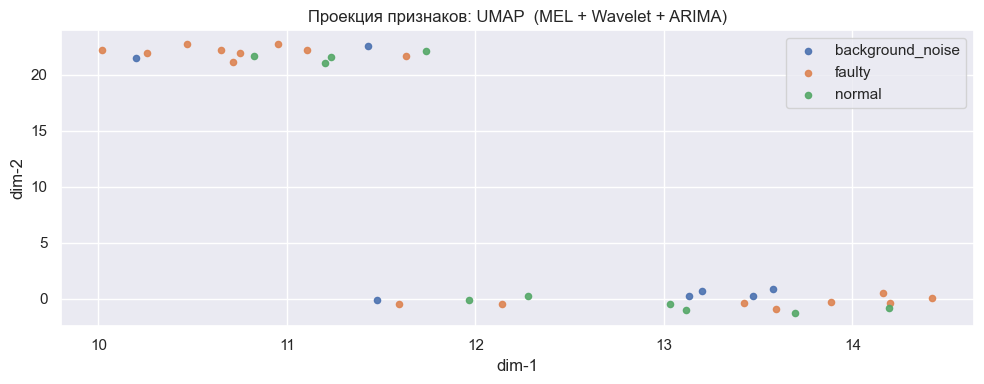

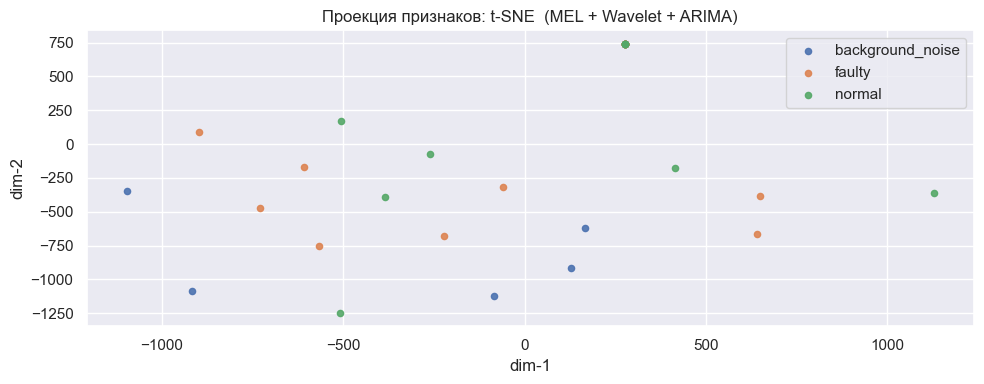

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# иначе проблемы с UMAP из-за конфликта имен
try:
    from umap import UMAP as _UMAP
    UMAP = _UMAP
except Exception:
    try:
        from umap.umap_ import UMAP as _UMAP2
        UMAP = _UMAP2
    except Exception:
        UMAP = None

import soundfile as soundfile_io
import plotly.graph_objects as plotly_go
import plotly.io as plotly_io
from IPython.display import HTML, display

# константы путей
artifacts_directory = Path("artifacts")
features_npz_path = artifacts_directory / "features.npz"
meta_csv_path = artifacts_directory / "meta.csv"
labels_train_csv_path = artifacts_directory / "labels_train.csv"

# проекции признаков на 2D (UMAP, t-SNE)

loaded_features = np.load(features_npz_path)
meta_dataframe = pd.read_csv(meta_csv_path)

feature_matrix = np.hstack([
    loaded_features["mel"],
    loaded_features["wavelet"],
    loaded_features["arima"]
]).astype(np.float32)

feature_matrix = np.nan_to_num(feature_matrix)

target_text_labels = meta_dataframe["target"].values
class_names, target_labels_encoded = np.unique(target_text_labels, return_inverse=True)

scaler = StandardScaler()
feature_matrix_standardized = scaler.fit_transform(feature_matrix)

umap_model = UMAP(n_neighbors=15, min_dist=0.1)
embedding_umap_2d = umap_model.fit_transform(feature_matrix_standardized)

number_of_samples = feature_matrix_standardized.shape[0]
tsne_perplexity = max(5, min(30, (number_of_samples - 1) // 3))
tsne_model = TSNE(n_components=2, init="pca", perplexity=tsne_perplexity)
embedding_tsne_2d = tsne_model.fit_transform(feature_matrix_standardized)

def plot_2d_embedding(embedding_2d, encoded_labels, class_name_list, plot_title):
    plt.figure(figsize=(10, 4))
    for class_index, class_name in enumerate(class_name_list):
        class_mask = (encoded_labels == class_index)
        plt.scatter(
            embedding_2d[class_mask, 0],
            embedding_2d[class_mask, 1],
            s=20,
            alpha=0.9,
            label=class_name
        )
    plt.title(plot_title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

plot_2d_embedding(
    embedding_2d=embedding_umap_2d,
    encoded_labels=target_labels_encoded,
    class_name_list=class_names,
    plot_title="Проекция признаков: UMAP  (MEL + Wavelet + ARIMA)"
)

plot_2d_embedding(
    embedding_2d=embedding_tsne_2d,
    encoded_labels=target_labels_encoded,
    class_name_list=class_names,
    plot_title="Проекция признаков: t-SNE  (MEL + Wavelet + ARIMA)"
)

# 3D Plotly

sample_rate_hz = 22_050
frame_length_seconds = 0.020
hop_length_seconds = 0.010
mel_filter_count = 64
mfcc_count = 13

fft_window_size = int(sample_rate_hz * frame_length_seconds)
hop_length_samples = int(sample_rate_hz * hop_length_seconds)

labels_train_dataframe = pd.read_csv(labels_train_csv_path)
example_wave_path = Path(labels_train_dataframe.iloc[0]["filepath"])

audio_signal, original_sample_rate = soundfile_io.read(example_wave_path)
if audio_signal.ndim > 1:
    audio_signal = audio_signal.mean(axis=1)

if original_sample_rate != sample_rate_hz:
    audio_signal = librosa.resample(
        y=audio_signal,
        orig_sr=original_sample_rate,
        target_sr=sample_rate_hz
    )

audio_signal = audio_signal.astype(np.float32)

mel_power_spectrogram = librosa.feature.melspectrogram(
    y=audio_signal,
    sr=sample_rate_hz,
    n_fft=fft_window_size,
    hop_length=hop_length_samples,
    n_mels=mel_filter_count
)

mel_decibel_spectrogram = librosa.power_to_db(mel_power_spectrogram + 1e-10)

mfcc_matrix = librosa.feature.mfcc(
    S=mel_decibel_spectrogram,
    n_mfcc=mfcc_count
)

time_axis_seconds = (np.arange(mfcc_matrix.shape[1]) * hop_length_samples) / sample_rate_hz
mfcc_index_axis = np.arange(mfcc_count)

plotly_figure = plotly_go.Figure(
    data=[
        plotly_go.Surface(
            z=mfcc_matrix,
            x=time_axis_seconds,
            y=mfcc_index_axis,
            colorbar={"title": "значение"}
        )
    ]
)

plotly_figure.update_layout(
    title=f"3D MFCC — {example_wave_path.name}",
    scene=dict(
        xaxis_title="Время (с)",
        yaxis_title="Индекс MFCC",
        zaxis_title="Значение"
    ),
    template="plotly_dark",
    margin=dict(l=0, r=0, t=40, b=0),
    height=520
)

html_fragment = plotly_io.to_html(
    plotly_figure,
    include_plotlyjs="cdn",
    full_html=False
)

display(HTML(html_fragment))


# Блок 5 — Модель 1: Gradient Boosting (табличные признаки)

#### Вот из-за малого количества записей, это не работает...

F1-weighted (validation): 0.4571
AUC-ROC OVR (validation): 0.5905

Classification report (validation):
                  precision    recall  f1-score   support

background_noise       0.00      0.00      0.00         1
          faulty       0.67      1.00      0.80         4
          normal       0.00      0.00      0.00         2

        accuracy                           0.57         7
       macro avg       0.22      0.33      0.27         7
    weighted avg       0.38      0.57      0.46         7



C:\Users\053458\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\053458\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\053458\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



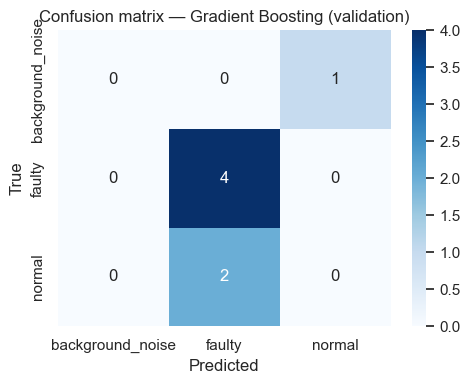

Модель сохранена в: artifacts\gbm.pkl
Валидационные предсказания сохранены в: artifacts/gbm_validation_predictions.csv


In [5]:
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# константы путей
artifacts_directory = Path("artifacts")
features_npz_path = artifacts_directory / "features.npz"
meta_csv_path = artifacts_directory / "meta.csv"

loaded_features = np.load(features_npz_path)
meta_dataframe = pd.read_csv(meta_csv_path)

# Собираем табличный вектор признаков на запись
feature_matrix = np.hstack([
    loaded_features["mel"],
    loaded_features["wavelet"],
    loaded_features["arima"]
]).astype(np.float32)
feature_matrix = np.nan_to_num(feature_matrix)

target_text_labels = meta_dataframe["target"].values
class_names, target_labels_encoded = np.unique(target_text_labels, return_inverse=True)

# Делим на обучение и валидацию
features_train, features_valid, labels_train, labels_valid = train_test_split(
    feature_matrix,
    target_labels_encoded,
    test_size=0.2,
    stratify=target_labels_encoded,
    random_state=42
)

# Обучаем простую бустинговую модель из sklearn
gbm_model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9
)
gbm_model.fit(features_train, labels_train)

# Предсказания и метрики
labels_valid_predicted = gbm_model.predict(features_valid)
labels_valid_proba = gbm_model.predict_proba(features_valid)

f1_weighted = f1_score(labels_valid, labels_valid_predicted, average="weighted")
auc_ovr = roc_auc_score(
    labels_valid,
    labels_valid_proba,
    multi_class="ovr",
    average="weighted"
)

print("F1-weighted (validation):", round(f1_weighted, 4))
print("AUC-ROC OVR (validation):", round(auc_ovr, 4))
print()
print("Classification report (validation):")
print(classification_report(labels_valid, labels_valid_predicted, target_names=class_names))

# Матрица ошибок
matrix = confusion_matrix(labels_valid, labels_valid_predicted)
plt.figure(figsize=(5, 4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion matrix — Gradient Boosting (validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Сохраняем модель и предсказания
model_path = artifacts_directory / "gbm.pkl"
with open(model_path, "wb") as model_file:
    pickle.dump({
        "model": gbm_model,
        "class_names": class_names
    }, model_file)

predictions_validation = pd.DataFrame({
    "filepath": meta_dataframe.iloc[features_valid.shape[0]*0:features_valid.shape[0]*0 + len(labels_valid)].reset_index(drop=True)["filepath"] if "filepath" in meta_dataframe.columns else pd.Series([""]*len(labels_valid)),
    "true_label": [class_names[i] for i in labels_valid],
    "predicted_label": [class_names[i] for i in labels_valid_predicted]
})
predictions_validation.to_csv(artifacts_directory / "gbm_validation_predictions.csv", index=False)

print("Модель сохранена в:", model_path)
print("Валидационные предсказания сохранены в: artifacts/gbm_validation_predictions.csv")


# Блок 6 — Модель 2: CRNN на MEL-спектрограммах

Epoch 1/20 | train_loss=1.1127 | F1w_valid=0.4156 | AUC_valid=0.2762
Epoch 2/20 | train_loss=1.0118 | F1w_valid=0.4156 | AUC_valid=0.5095
Epoch 3/20 | train_loss=0.9544 | F1w_valid=0.4156 | AUC_valid=0.7000
Epoch 4/20 | train_loss=0.9034 | F1w_valid=0.4156 | AUC_valid=0.5571
Epoch 5/20 | train_loss=0.8762 | F1w_valid=0.4156 | AUC_valid=0.5571
Epoch 6/20 | train_loss=0.8354 | F1w_valid=0.4156 | AUC_valid=0.5571
Epoch 7/20 | train_loss=0.8138 | F1w_valid=0.4156 | AUC_valid=0.5571
Epoch 8/20 | train_loss=0.7878 | F1w_valid=0.4571 | AUC_valid=0.5286
Epoch 9/20 | train_loss=0.7665 | F1w_valid=0.4571 | AUC_valid=0.5762
Epoch 10/20 | train_loss=0.7466 | F1w_valid=0.4571 | AUC_valid=0.5762
Epoch 11/20 | train_loss=0.7367 | F1w_valid=0.4286 | AUC_valid=0.5762
Epoch 12/20 | train_loss=0.7220 | F1w_valid=0.4286 | AUC_valid=0.5762
Epoch 13/20 | train_loss=0.7538 | F1w_valid=0.4286 | AUC_valid=0.5762
Epoch 14/20 | train_loss=0.6893 | F1w_valid=0.1905 | AUC_valid=0.5762
Epoch 15/20 | train_loss=0.69

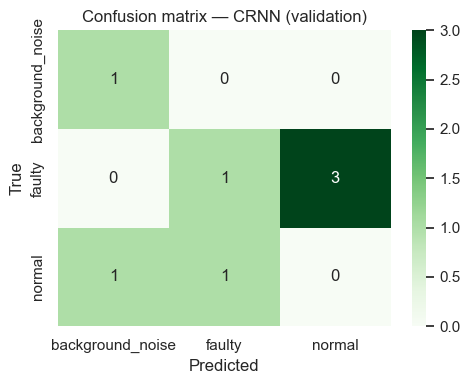

CRNN сохранён в: artifacts\crnn.pth


In [6]:
import soundfile as soundfile_io
import torch
import torch.nn as torch_nn
import torch.optim as torch_optim
from torch.utils.data import Dataset, DataLoader

# константы путей
artifacts_directory = Path("artifacts")
labels_train_csv_path = artifacts_directory / "labels_train.csv"

# Параметры аудио из репозитория
sample_rate_hz = 22_050
frame_length_seconds = 0.020
hop_length_seconds = 0.010
mel_filter_count = 64

fft_window_size = int(sample_rate_hz * frame_length_seconds)
hop_length_samples = int(sample_rate_hz * hop_length_seconds)

# Длина по времени (кадры MEL), до которой приводим (обрезаем/паддим)
max_mel_frames = 256

labels_dataframe = pd.read_csv(labels_train_csv_path)
class_names, labels_encoded = np.unique(labels_dataframe["target"].values, return_inverse=True)
labels_dataframe["encoded"] = labels_encoded

train_dataframe, valid_dataframe = train_test_split(
    labels_dataframe,
    test_size=0.2,
    stratify=labels_dataframe["encoded"],
    random_state=42
)

def load_audio_mono_resampled(audio_path: Path, target_sr: int) -> np.ndarray:
    signal, original_sr = soundfile_io.read(audio_path)
    if signal.ndim > 1:
        signal = signal.mean(axis=1)
    if original_sr != target_sr:
        signal = librosa.resample(y=signal, orig_sr=original_sr, target_sr=target_sr)
    return signal.astype(np.float32)

def compute_log_mel(signal_array: np.ndarray) -> np.ndarray:
    mel_power = librosa.feature.melspectrogram(
        y=signal_array,
        sr=sample_rate_hz,
        n_fft=fft_window_size,
        hop_length=hop_length_samples,
        n_mels=mel_filter_count
    )
    mel_db = librosa.power_to_db(mel_power + 1e-10)
    # нормируем в диапазон ~0..1 по записи, чтобы попытаться стабилизировать обучение
    mel_min = np.min(mel_db)
    mel_max = np.max(mel_db)
    mel_norm = (mel_db - mel_min) / (mel_max - mel_min + 1e-6)
    return mel_norm.astype(np.float32)

def pad_or_truncate_mel(mel_matrix: np.ndarray, target_frames: int) -> np.ndarray:
    current_frames = mel_matrix.shape[1]
    if current_frames == target_frames:
        return mel_matrix
    if current_frames > target_frames:
        return mel_matrix[:, :target_frames]
    padding = np.zeros((mel_matrix.shape[0], target_frames - current_frames), dtype=np.float32)
    return np.concatenate([mel_matrix, padding], axis=1)

class MelDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        self.dataframe = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index: int):
        row = self.dataframe.iloc[index]
        audio_path = Path(row["filepath"])
        label_index = int(row["encoded"])
        signal_array = load_audio_mono_resampled(audio_path, sample_rate_hz)
        mel_matrix = compute_log_mel(signal_array)
        mel_matrix_fixed = pad_or_truncate_mel(mel_matrix, max_mel_frames)
        # Для CNN ожидаем (канал, высота, ширина) = (1, n_mels, frames)
        tensor = torch.from_numpy(mel_matrix_fixed[None, :, :])
        return tensor, label_index

train_dataset = MelDataset(train_dataframe)
valid_dataset = MelDataset(valid_dataframe)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

class SimpleCRNN(torch_nn.Module):
    def __init__(self, n_mels: int, n_classes: int):
        super().__init__()
        self.conv_block = torch_nn.Sequential(
            torch_nn.Conv2d(1, 16, kernel_size=3, padding=1),
            torch_nn.BatchNorm2d(16),
            torch_nn.ReLU(),
            torch_nn.MaxPool2d(kernel_size=(2, 2)),
            torch_nn.Conv2d(16, 32, kernel_size=3, padding=1),
            torch_nn.BatchNorm2d(32),
            torch_nn.ReLU(),
            torch_nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.gru_hidden_size = 64
        self.gru = torch_nn.GRU(
            input_size=(n_mels // 4) * 32,
            hidden_size=self.gru_hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = torch_nn.Sequential(
            torch_nn.Linear(self.gru_hidden_size * 2, 64),
            torch_nn.ReLU(),
            torch_nn.Linear(64, n_classes)
        )

    def forward(self, x):
        # x: (batch, 1, n_mels, frames)
        x = self.conv_block(x)
        # (batch, channels=32, n_mels/4, frames/4)
        batch_size, channels, freq_bins, time_steps = x.shape
        # сворачиваем частотные измерения в фичи, а время оставляем
        x = x.permute(0, 3, 1, 2).contiguous()  # (batch, time, channels, freq)
        x = x.view(batch_size, time_steps, channels * freq_bins)  # (batch, time, features)
        x, _ = self.gru(x)  # (batch, time, 2*hidden)
        # берём усреднение по времени
        x = torch.mean(x, dim=1)  # (batch, 2*hidden)
        logits = self.classifier(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCRNN(n_mels=mel_filter_count, n_classes=len(class_names)).to(device)

optimizer = torch_optim.Adam(model.parameters(), lr=1e-3)
criterion = torch_nn.CrossEntropyLoss()

num_epochs = 20 # увеличение не поможет...

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    for batch_data, batch_labels in train_loader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        logits = model(batch_data)
        loss = criterion(logits, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_data.size(0)

    average_train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    all_true = []
    all_pred = []
    all_proba = []
    with torch.no_grad():
        for batch_data, batch_labels in valid_loader:
            batch_data = batch_data.to(device)
            logits = model(batch_data)
            probabilities = torch.softmax(logits, dim=1).cpu().numpy()
            predictions = np.argmax(probabilities, axis=1)

            all_true.extend(batch_labels.numpy().tolist())
            all_pred.extend(predictions.tolist())
            all_proba.extend(probabilities.tolist())

    f1_weighted_valid = f1_score(all_true, all_pred, average="weighted")
    try:
        auc_ovr_valid = roc_auc_score(all_true, np.array(all_proba), multi_class="ovr", average="weighted")
    except Exception:
        auc_ovr_valid = float("nan")

    print(f"Epoch {epoch}/{num_epochs} | train_loss={average_train_loss:.4f} | F1w_valid={f1_weighted_valid:.4f} | AUC_valid={auc_ovr_valid:.4f}")

# Финальная оценка и матрица ошибок
print()
print("Classification report (validation, CRNN):")
print(classification_report(all_true, all_pred, target_names=class_names))

matrix = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion matrix — CRNN (validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Сохраняем веса модели
crnn_path = artifacts_directory / "crnn.pth"
torch.save({
    "state_dict": model.state_dict(),
    "class_names": class_names,
    "config": {
        "sample_rate_hz": sample_rate_hz,
        "frame_length_seconds": frame_length_seconds,
        "hop_length_seconds": hop_length_seconds,
        "mel_filter_count": mel_filter_count,
        "max_mel_frames": max_mel_frames
    }
}, crnn_path)
print("CRNN сохранён в:", crnn_path)


# Блок 7 — Интерпретация

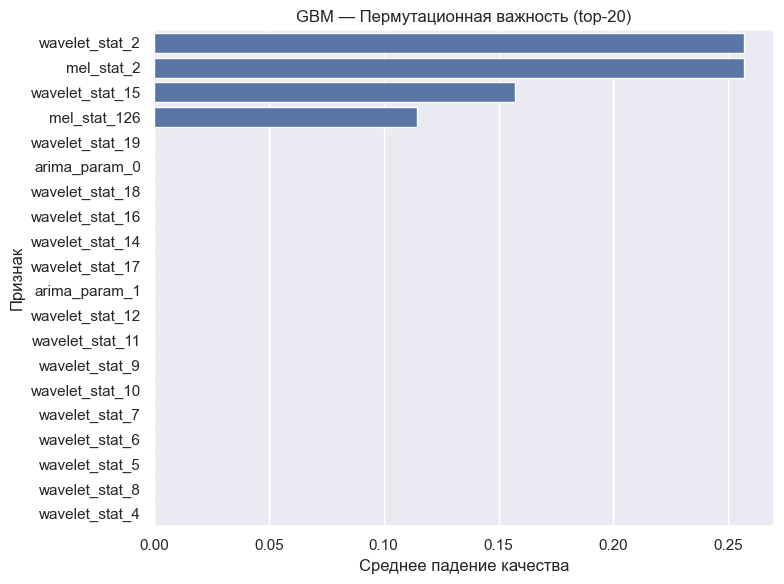

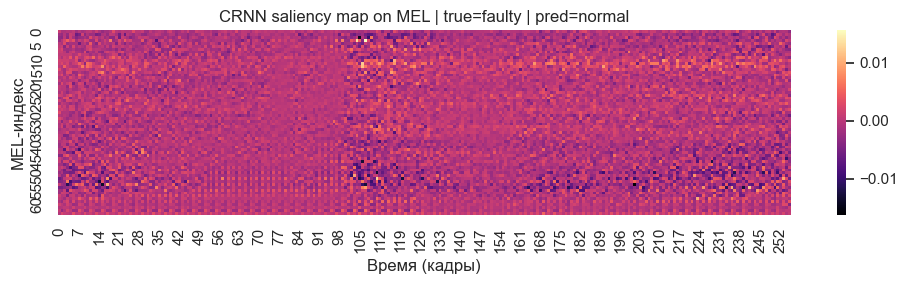

Аномальные по saliency сегменты сохранены в: artifacts/crnn_anomalous_segments_example.csv


In [7]:
from sklearn.inspection import permutation_importance

# константы путей
artifacts_directory = Path("artifacts")
features_npz_path = artifacts_directory / "features.npz"
meta_csv_path = artifacts_directory / "meta.csv"

# интерпретация Gradient Boosting (Permutation Importance)

loaded_features = np.load(features_npz_path)
meta_dataframe = pd.read_csv(meta_csv_path)

feature_matrix_mel = loaded_features["mel"].astype(np.float32)
feature_matrix_wavelet = loaded_features["wavelet"].astype(np.float32)
feature_matrix_arima = loaded_features["arima"].astype(np.float32)

# состав фич для анализа
feature_matrix = np.hstack([feature_matrix_mel, feature_matrix_wavelet, feature_matrix_arima])
feature_matrix = np.nan_to_num(feature_matrix)

# формируем имена признаков
mel_feature_count = feature_matrix_mel.shape[1]
wavelet_feature_count = feature_matrix_wavelet.shape[1]
arima_feature_count = feature_matrix_arima.shape[1]

mel_feature_names = [f"mel_stat_{i}" for i in range(mel_feature_count)]
wavelet_feature_names = [f"wavelet_stat_{i}" for i in range(wavelet_feature_count)]
arima_feature_names = [f"arima_param_{i}" for i in range(arima_feature_count)]
all_feature_names = mel_feature_names + wavelet_feature_names + arima_feature_names

target_text_labels = meta_dataframe["target"].values
class_names, target_labels_encoded = np.unique(target_text_labels, return_inverse=True)

features_train, features_valid, labels_train, labels_valid = train_test_split(
    feature_matrix, target_labels_encoded, test_size=0.2, stratify=target_labels_encoded, random_state=42
)

# загружаем обученную нами GBM
gbm_path = artifacts_directory / "gbm.pkl"
with open(gbm_path, "rb") as model_file:
    saved = pickle.load(model_file)
gbm_model = saved["model"]
class_names_loaded = saved["class_names"]

# пермутационная важность на валидации
importance_result = permutation_importance(
    gbm_model,
    features_valid,
    labels_valid,
    n_repeats=10,
    random_state=42,
    n_jobs=1
)

importances_mean = importance_result.importances_mean
indices_sorted = np.argsort(importances_mean)[::-1][:20]  # топ-20

plt.figure(figsize=(8, 6))
sns.barplot(
    x=importances_mean[indices_sorted],
    y=[all_feature_names[i] for i in indices_sorted],
    orient="h"   
)
plt.title("GBM — Пермутационная важность (top-20)")
plt.xlabel("Среднее падение качества")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

# CRNN — простая градиентная карта на MEL для одного примера
# Параметры MEL должны совпадать с Блоком 6
sample_rate_hz = 22_050
frame_length_seconds = 0.020
hop_length_seconds = 0.010
mel_filter_count = 64
max_mel_frames = 256

fft_window_size = int(sample_rate_hz * frame_length_seconds)
hop_length_samples = int(sample_rate_hz * hop_length_seconds)

# загрузим один пример из валидации (из того же сплита, что в Блоке 6)
labels_train_csv_path = artifacts_directory / "labels_train.csv"
labels_dataframe = pd.read_csv(labels_train_csv_path)
class_names_all, labels_encoded_all = np.unique(labels_dataframe["target"].values, return_inverse=True)
labels_dataframe["encoded"] = labels_encoded_all

train_dataframe, valid_dataframe = train_test_split(
    labels_dataframe,
    test_size=0.2,
    stratify=labels_dataframe["encoded"],
    random_state=42
)

example_row = valid_dataframe.iloc[0]
example_path = Path(example_row["filepath"])
true_label_index = int(example_row["encoded"])

def load_audio_mono_resampled(audio_path: Path, target_sr: int) -> np.ndarray:
    signal, original_sr = soundfile_io.read(audio_path)
    if signal.ndim > 1:
        signal = signal.mean(axis=1)
    if original_sr != target_sr:
        signal = librosa.resample(y=signal, orig_sr=original_sr, target_sr=target_sr)
    return signal.astype(np.float32)

def compute_log_mel(signal_array: np.ndarray) -> np.ndarray:
    mel_power = librosa.feature.melspectrogram(
        y=signal_array,
        sr=sample_rate_hz,
        n_fft=fft_window_size,
        hop_length=hop_length_samples,
        n_mels=mel_filter_count
    )
    mel_db = librosa.power_to_db(mel_power + 1e-10)
    mel_min = np.min(mel_db)
    mel_max = np.max(mel_db)
    mel_norm = (mel_db - mel_min) / (mel_max - mel_min + 1e-6)
    return mel_norm.astype(np.float32)

def pad_or_truncate_mel(mel_matrix: np.ndarray, target_frames: int) -> np.ndarray:
    current_frames = mel_matrix.shape[1]
    if current_frames == target_frames:
        return mel_matrix
    if current_frames > target_frames:
        return mel_matrix[:, :target_frames]
    padding = np.zeros((mel_matrix.shape[0], target_frames - current_frames), dtype=np.float32)
    return np.concatenate([mel_matrix, padding], axis=1)

# готовим вход и грузим CRNN
mel_matrix = compute_log_mel(load_audio_mono_resampled(example_path, sample_rate_hz))
mel_matrix_fixed = pad_or_truncate_mel(mel_matrix, max_mel_frames)
input_tensor = torch.from_numpy(mel_matrix_fixed[None, None, :, :]).float()  # (1,1,n_mels,T)

crnn_path = artifacts_directory / "crnn.pth"
checkpoint = torch.load(crnn_path, map_location="cpu", weights_only=False)
class_names_crnn = checkpoint["class_names"]

class SimpleCRNN(torch_nn.Module):
    def __init__(self, n_mels: int, n_classes: int):
        super().__init__()
        self.conv_block = torch_nn.Sequential(
            torch_nn.Conv2d(1, 16, kernel_size=3, padding=1),
            torch_nn.BatchNorm2d(16),
            torch_nn.ReLU(),
            torch_nn.MaxPool2d(kernel_size=(2, 2)),
            torch_nn.Conv2d(16, 32, kernel_size=3, padding=1),
            torch_nn.BatchNorm2d(32),
            torch_nn.ReLU(),
            torch_nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.gru_hidden_size = 64
        self.gru = torch_nn.GRU(
            input_size=(n_mels // 4) * 32,
            hidden_size=self.gru_hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = torch_nn.Sequential(
            torch_nn.Linear(self.gru_hidden_size * 2, 64),
            torch_nn.ReLU(),
            torch_nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        batch_size, channels, freq_bins, time_steps = x.shape
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(batch_size, time_steps, channels * freq_bins)
        x, _ = self.gru(x)
        x = torch.mean(x, dim=1)
        logits = self.classifier(x)
        return logits

model = SimpleCRNN(n_mels=mel_filter_count, n_classes=len(class_names_crnn))
model.load_state_dict(checkpoint["state_dict"])
model.eval()

# Saliency: градиенты логита предсказанного класса по входу (MEL)
input_tensor.requires_grad_(True)
logits = model(input_tensor)
predicted_index = int(torch.argmax(logits, dim=1))
score = logits[0, predicted_index]
model.zero_grad()
score.backward()
saliency = input_tensor.grad.detach().numpy()[0, 0]  # (n_mels, T)

# визуализация карты важности
plt.figure(figsize=(10, 3))
sns.heatmap(saliency, cmap="magma")
plt.title(f"CRNN saliency map on MEL | true={class_names_crnn[true_label_index]} | pred={class_names_crnn[predicted_index]}")
plt.xlabel("Время (кадры)")
plt.ylabel("MEL-индекс")
plt.tight_layout()
plt.show()

# Маркировка аномальных сегментов» по saliency
# Простая эвристика: берём порог как 90-й перцентиль по времени (усреднив по частоте),
# отмечаем интервалы, где активность выше порога.

time_activity = np.mean(np.abs(saliency), axis=0)  # усредняем по MEL-оси
threshold_value = np.percentile(time_activity, 90)
active_flags = time_activity >= threshold_value

segments = []
start_index = None
for index, flag in enumerate(active_flags):
    if flag and start_index is None:
        start_index = index
    if (not flag or index == len(active_flags) - 1) and start_index is not None:
        end_index = index if not flag else index + 1
        start_time = start_index * (hop_length_samples / sample_rate_hz)
        end_time = end_index * (hop_length_samples / sample_rate_hz)
        segments.append((start_time, end_time))
        start_index = None

segments_dataframe = pd.DataFrame(segments, columns=["t_start_sec", "t_end_sec"])
segments_dataframe.to_csv(artifacts_directory / "crnn_anomalous_segments_example.csv", index=False)

print("Аномальные по saliency сегменты сохранены в: artifacts/crnn_anomalous_segments_example.csv")


# Блок 8 — Оценка и сравнение представлений

         feature_set  f1_weighted_mean  f1_weighted_std  auc_ovr_mean  \
0           MEL_only          0.569819         0.133884      0.685317   
1  MEL+Wavelet+ARIMA          0.510635         0.197464      0.659603   
2   STFT+CQT+Wavelet          0.601746         0.186386      0.769127   

   auc_ovr_std  
0     0.165634  
1     0.165794  
2     0.108026  


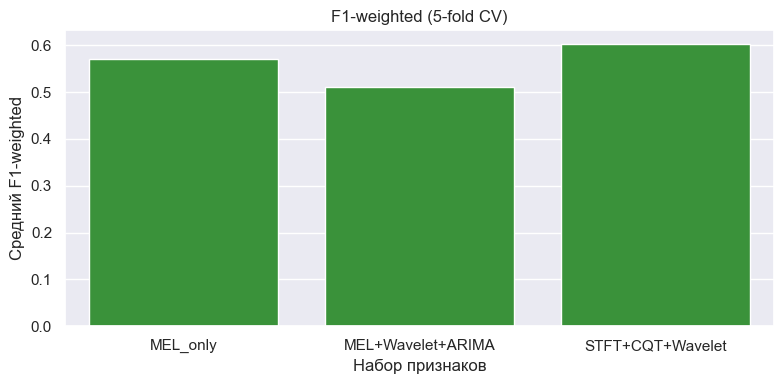

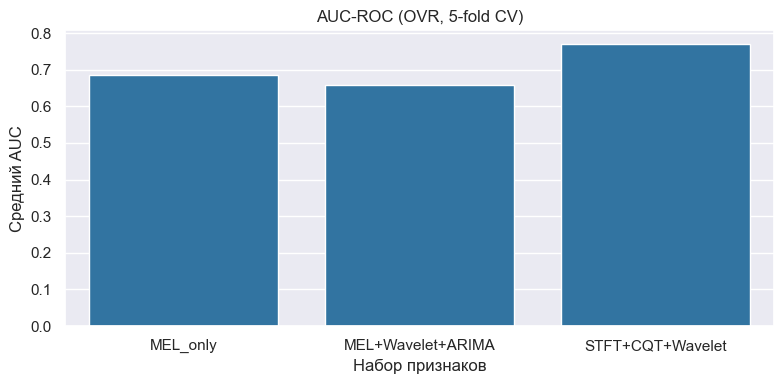

Результаты сохранены в: artifacts/ab_results_gbm.csv


In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score

# константы путей
artifacts_directory = Path("artifacts")
features_npz_path = artifacts_directory / "features.npz"
meta_csv_path = artifacts_directory / "meta.csv"

loaded_features = np.load(features_npz_path)
meta_dataframe = pd.read_csv(meta_csv_path)

feature_sets = {
    "MEL_only": loaded_features["mel"],
    "MEL+Wavelet+ARIMA": np.hstack([loaded_features["mel"], loaded_features["wavelet"], loaded_features["arima"]]),
    "STFT+CQT+Wavelet": np.hstack([loaded_features["stft"], loaded_features["cqt"], loaded_features["wavelet"]])
}

target_text_labels = meta_dataframe["target"].values
class_names, target_labels_encoded = np.unique(target_text_labels, return_inverse=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_rows = []

for feature_set_name, feature_set_matrix in feature_sets.items():
    feature_set_matrix = feature_set_matrix.astype(np.float32)
    feature_set_matrix = np.nan_to_num(feature_set_matrix)

    f1_scores = []
    auc_scores = []

    for train_index, valid_index in cv.split(feature_set_matrix, target_labels_encoded):
        X_train = feature_set_matrix[train_index]
        X_valid = feature_set_matrix[valid_index]
        y_train = target_labels_encoded[train_index]
        y_valid = target_labels_encoded[valid_index]

        model = GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.9
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_valid)
        y_proba = model.predict_proba(X_valid)

        f1_scores.append(f1_score(y_valid, y_pred, average="weighted"))
        try:
            auc_scores.append(roc_auc_score(y_valid, y_proba, multi_class="ovr", average="weighted"))
        except Exception:
            auc_scores.append(float("nan"))

    results_rows.append({
        "feature_set": feature_set_name,
        "f1_weighted_mean": float(np.nanmean(f1_scores)),
        "f1_weighted_std": float(np.nanstd(f1_scores)),
        "auc_ovr_mean": float(np.nanmean(auc_scores)),
        "auc_ovr_std": float(np.nanstd(auc_scores))
    })

results_dataframe = pd.DataFrame(results_rows)
results_dataframe.to_csv(artifacts_directory / "ab_results_gbm.csv", index=False)
print(results_dataframe)

plt.figure(figsize=(8, 4))
sns.barplot(data=results_dataframe, x="feature_set", y="f1_weighted_mean", color="#2ca02c")
plt.title("F1-weighted (5-fold CV)")
plt.xlabel("Набор признаков")
plt.ylabel("Средний F1-weighted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=results_dataframe, x="feature_set", y="auc_ovr_mean", color="#1f77b4")
plt.title("AUC-ROC (OVR, 5-fold CV)")
plt.xlabel("Набор признаков")
plt.ylabel("Средний AUC")
plt.tight_layout()
plt.show()

print("Результаты сохранены в: artifacts/ab_results_gbm.csv")


# Блок 9 — Инференс 

In [9]:
import warnings
from scipy.stats import skew, kurtosis
import pywt
from statsmodels.tsa.arima.model import ARIMA

# константы путей
artifacts_directory = Path("artifacts")
labels_test_csv_path = artifacts_directory / "labels_test.csv"
gbm_model_path = artifacts_directory / "gbm.pkl"

# параметры аудио и спектров как в репозитории
sample_rate_hz = 22_050
frame_length_seconds = 0.020
hop_length_seconds = 0.010
mel_filter_count = 64

fft_window_size = int(sample_rate_hz * frame_length_seconds)
hop_length_samples = int(sample_rate_hz * hop_length_seconds)

# минимальные длины для безопасных спектрограмм
min_len_for_stft = max(fft_window_size, 2048)
min_len_for_cqt = 8192

def load_audio_mono_resampled(audio_path: Path, target_sr: int) -> np.ndarray:
    audio_signal, original_sr = soundfile_io.read(audio_path)
    if audio_signal.ndim > 1:
        audio_signal = audio_signal.mean(axis=1)
    if original_sr != target_sr:
        audio_signal = librosa.resample(y=audio_signal, orig_sr=original_sr, target_sr=target_sr)
    return audio_signal.astype(np.float32)

def pad_if_too_short(signal_array: np.ndarray, min_length: int) -> np.ndarray:
    if len(signal_array) < min_length:
        padding = min_length - len(signal_array)
        signal_array = np.pad(signal_array, (0, padding))
    return signal_array

def energy_segments(signal_array: np.ndarray, threshold_db: float = -35.0, min_len_sec: float = 0.15):
    rms = librosa.feature.rms(
        y=signal_array,
        frame_length=fft_window_size,
        hop_length=hop_length_samples)[0]
    rms_db = 20 * np.log10(rms + 1e-10)
    active = rms_db > threshold_db
    segments = []
    start_index = None
    for i, is_on in enumerate(active):
        if is_on and start_index is None:
            start_index = i
        if (not is_on or i == len(active) - 1) and start_index is not None:
            end_index = i if not is_on else i + 1
            t0 = start_index * hop_length_samples / sample_rate_hz
            t1 = end_index * hop_length_samples / sample_rate_hz
            if (t1 - t0) >= min_len_sec:
                segments.append((t0, t1))
            start_index = None
    return segments

def keep_active_parts(signal_array: np.ndarray) -> np.ndarray:
    segments = energy_segments(signal_array)
    if not segments:
        return signal_array
    parts = [signal_array[int(t0 * sample_rate_hz): int(t1 * sample_rate_hz)] for (t0, t1) in segments]
    if len(parts) == 0:
        return signal_array
    return np.concatenate(parts)

def mel_db(signal_array: np.ndarray) -> np.ndarray:
    y = pad_if_too_short(signal_array, min_len_for_stft)
    mel_power = librosa.feature.melspectrogram(
        y=y,
        sr=sample_rate_hz,
        n_fft=fft_window_size,
        hop_length=hop_length_samples,
        n_mels=mel_filter_count
    )
    mel_db_matrix = librosa.power_to_db(mel_power + 1e-10)
    return mel_db_matrix

def stft_db(signal_array: np.ndarray) -> np.ndarray:
    y = pad_if_too_short(signal_array, min_len_for_stft)
    stft_complex = librosa.stft(
        y=y,
        n_fft=fft_window_size,
        hop_length=hop_length_samples,
        win_length=fft_window_size,
        window="hann"
    )
    stft_db_matrix = librosa.amplitude_to_db(np.abs(stft_complex) + 1e-10)
    return stft_db_matrix

def cqt_db(signal_array: np.ndarray) -> np.ndarray:
    y = pad_if_too_short(signal_array, min_len_for_cqt)
    cqt_complex = librosa.cqt(
        y=y,
        sr=sample_rate_hz,
        hop_length=hop_length_samples,
        bins_per_octave=24,
        n_bins=7 * 24
    )
    cqt_db_matrix = librosa.amplitude_to_db(np.abs(cqt_complex) + 1e-10)
    return cqt_db_matrix

def summarize_spectrogram(spec_matrix: np.ndarray) -> np.ndarray:
    flat = spec_matrix.ravel()
    global_mean = float(np.mean(flat))
    global_std = float(np.std(flat))
    global_skew = float(skew(flat))
    global_kurt = float(kurtosis(flat))
    mean_per_freq = np.mean(spec_matrix, axis=1).astype(np.float32)
    std_per_freq = np.std(spec_matrix, axis=1).astype(np.float32)
    summary_vector = np.concatenate(
        [np.array([global_mean, global_std, global_skew, global_kurt], dtype=np.float32),
         mean_per_freq,
         std_per_freq],
        axis=0
    )
    return summary_vector

def wavelet_features(signal_array: np.ndarray, wavelet: str = "db4", level: int = 4) -> np.ndarray:
    coeffs = pywt.wavedec(signal_array, wavelet, level=level)
    features = []
    for c in coeffs:
        c = c.astype(np.float32)
        features.extend([
            float(np.mean(c)),
            float(np.std(c)),
            float(skew(c)),
            float(kurtosis(c))
        ])
    return np.array(features, dtype=np.float32)

def arima_on_mfcc0(spec_mel_db: np.ndarray) -> np.ndarray:
    try:
        mfcc = librosa.feature.mfcc(S=spec_mel_db, n_mfcc=13)
        series = mfcc[0].astype(np.float32)
        if series.shape[0] < 30:
            return np.zeros(3, dtype=np.float32)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = ARIMA(series, order=(1, 0, 1),
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            res = model.fit()
        params = list(res.params.values)[:3]
        return np.array(params, dtype=np.float32)
    except Exception:
        return np.zeros(3, dtype=np.float32)

def extract_features_for_file(audio_path: Path) -> np.ndarray:
    signal_array = load_audio_mono_resampled(audio_path, sample_rate_hz)
    signal_array = keep_active_parts(signal_array)

    mel_matrix_db = mel_db(signal_array)
    stft_matrix_db = stft_db(signal_array)   
    cqt_matrix_db = cqt_db(signal_array)     

    mel_summary = summarize_spectrogram(mel_matrix_db)
    wavelet_summary = wavelet_features(signal_array)
    arima_summary = arima_on_mfcc0(mel_matrix_db)

    feature_vector = np.hstack([mel_summary, wavelet_summary, arima_summary]).astype(np.float32)
    feature_vector = np.nan_to_num(feature_vector)
    return feature_vector

# GBM
with open(gbm_model_path, "rb") as model_file:
    saved_obj = pickle.load(model_file)
gbm_model = saved_obj["model"]
class_names_array = saved_obj["class_names"]
class_names_list = list(class_names_array)

# читаем список тестовых файлов
test_dataframe = pd.read_csv(labels_test_csv_path)

# пройдёмся по всем файлам и соберём предсказания + истину, если есть (а бывает что и нет...)
predicted_rows = []
for _, row in test_dataframe.iterrows():
    audio_path = Path(row["filepath"])
    true_target = row["target"] if "target" in row and pd.notna(row["target"]) else None
    raw_label = row["raw_label"] if "raw_label" in row else None

    feature_vector = extract_features_for_file(audio_path)
    feature_vector_2d = feature_vector[None, :]

    probabilities = gbm_model.predict_proba(feature_vector_2d)[0]
    predicted_index = int(np.argmax(probabilities))
    predicted_label = class_names_list[predicted_index]

    # аккуратно добавим вероятности по известным именам классов
    prob_background = float(probabilities[class_names_list.index("background_noise")]) if "background_noise" in class_names_list else np.nan
    prob_faulty = float(probabilities[class_names_list.index("faulty")]) if "faulty" in class_names_list else np.nan
    prob_normal = float(probabilities[class_names_list.index("normal")]) if "normal" in class_names_list else np.nan

    predicted_rows.append({
        "filepath": str(audio_path),
        "raw_label": raw_label,            
        "true_target": true_target,        
        "predicted_label": predicted_label,
        "prob_background_noise": prob_background,
        "prob_faulty": prob_faulty,
        "prob_normal": prob_normal
    })

predictions_dataframe = pd.DataFrame(predicted_rows)


def compare_true_pred(row):
    if pd.isna(row["true_target"]) or row["true_target"] in [None, ""]:
        return np.nan
    return bool(row["true_target"] == row["predicted_label"])

predictions_dataframe["is_correct"] = predictions_dataframe.apply(compare_true_pred, axis=1)

predictions_output_path = artifacts_directory / "predictions_testing.csv"
predictions_dataframe.to_csv(predictions_output_path, index=False)

print("Инференс по testing завершён.")
print("Сохранено в:", predictions_output_path)
display(predictions_dataframe)


C:\Users\053458\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning:

n_fft=8192 is too large for input signal of length=5513

C:\Users\053458\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning:

n_fft=8192 is too large for input signal of length=5513

C:\Users\053458\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning:

n_fft=8192 is too large for input signal of length=5513



Инференс по testing завершён.
Сохранено в: artifacts\predictions_testing.csv


filepath         raw_label  \
0  C:\Users\053458\Desktop\ML\gerion\ai-mechanic-...           unknown   
1  C:\Users\053458\Desktop\ML\gerion\ai-mechanic-...           unknown   
2  C:\Users\053458\Desktop\ML\gerion\ai-mechanic-...           testing   
3  C:\Users\053458\Desktop\ML\gerion\ai-mechanic-...            idling   
4  C:\Users\053458\Desktop\ML\gerion\ai-mechanic-...  Background Noise   

        true_target   predicted_label  prob_background_noise  prob_faulty  \
0              None  background_noise               0.665766     0.004506   
1              None  background_noise               0.672009     0.005547   
2              None  background_noise               0.559913     0.000003   
3            normal            normal               0.000038     0.000001   
4  background_noise            faulty               0.156907     0.541221   

   prob_normal is_correct  
0     0.329728        NaN  
1     0.322445        NaN  
2     0.440084        NaN  
3     0.999961       True  
4     0.301872      False

# Блок 10 — Выводы

In [10]:

# константы путей
artifacts_directory = Path("artifacts")
ab_results_path = artifacts_directory / "ab_results_gbm.csv"


ab_results = pd.read_csv(ab_results_path)
print("Итоги A/B по наборам признаков (F1 и AUC):")
display(ab_results)



Итоги A/B по наборам признаков (F1 и AUC):


feature_set  f1_weighted_mean  f1_weighted_std  auc_ovr_mean  \
0           MEL_only          0.569819         0.133884      0.685317   
1  MEL+Wavelet+ARIMA          0.510635         0.197464      0.659603   
2   STFT+CQT+Wavelet          0.601746         0.186386      0.769127   

   auc_ovr_std  
0     0.165634  
1     0.165794  
2     0.108026